#### GETTING THE DATA :

In [1]:
from obsei.source import YoutubeScrapperSource, YoutubeScrapperConfig

c:\Users\Ahouz\anaconda3\envs\NLP\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
video_url = "https://www.youtube.com/watch?v=QuO7GNgCwBk&ab_channel=Forsen%27sGiftbox"
video_url

'https://www.youtube.com/watch?v=QuO7GNgCwBk&ab_channel=Forsen%27sGiftbox'

In [3]:
source_config = YoutubeScrapperConfig(
    video_url= video_url,
    fetch_replies=False,
    max_comments=20,
    lookup_period="1Y",
)

In [4]:
source = YoutubeScrapperSource()

source_response_list = source.lookup(source_config)

09/13/2022 23:22:14 - WARNING - obsei.misc.youtube_reviews_scrapper -   Unable to set sorting


In [28]:

comments = []
likes = []
for idx, source_response in enumerate(source_response_list):
    comments.append(source_response.__dict__['meta']['text'])
    likes.append(source_response.__dict__['meta']['votes'])
likes = [int(like) for like in likes]


[24, 40, 35, 31, 10, 1, 12, 9, 0, 2, 1, 5, 4, 0, 2, 4, 2, 5]


In [29]:
print(comments)
print(likes)

['Uhm excuse me what do you mean by "NEW CHAMPION" ? The dead by daylight characters are called Killers Mrs. Giftbox I hope this doesn\'t happen again or you will need some correction', '>Champion\n\nThis is your brain on League of Lesbians.', 'Wesker pagman pogu pog my king 😍😍😍😍', 'new youtube pfp monkaOMEGA', 'Where is part #1. The thumbnail says this is part two but where is part one? Please clarify', 'I was the clicking Chris lule. The bill was in the other locker but I opened the wrong one', 'sweat by daylight PagMan', 'Campsen LULE', 'god gamer dog tamer nina eliminator', 'CHAMPION LULE', 'MegaLUL CAMP EM MR FORS', 'Campsen', 'quality for ants LULE', 'Wesker can get taunts on every other action but not Freddy fucking kreuger sm fucking h', '360sen PagMan', '306p wutface', 'ada wong forsenCoomer', 'God this game is so stupid...']
[24, 40, 35, 31, 10, 1, 12, 9, 0, 2, 1, 5, 4, 0, 2, 4, 2, 5]


In [8]:
import pandas

##### DOWNLOADING TWITTER SENTIMENT PRETRAINED MODEL :

In [10]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request


In [12]:
# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

In [13]:

tokenizer = AutoTokenizer.from_pretrained(MODEL)
# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL) # load the pretrained bert model for tweet sentiment classification
model.save_pretrained(MODEL)


In [14]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


#### FINETUNING ?

#### USING THE MODEL ON THE DATA :

In [30]:
label_length = len(labels)
print(label_length)
vid_score = [0 for i in range(label_length)]
print(likes)

3
[24, 40, 35, 31, 10, 1, 12, 9, 0, 2, 1, 5, 4, 0, 2, 4, 2, 5]


In [31]:
comment_nbr = len(comments)
for j in range(comment_nbr):
    comment = comments[j]
    like_nbr = likes[j]
    comment = preprocess(comment)
    encoded_input = tokenizer(comment, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)
    ranking = ranking[::-1]

    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        vid_score[ranking[i]] += s*like_nbr
        #print(f"{i+1}) {l} {np.round(float(s), 4)}")
like_sum = sum(likes)
vid_score = [e/like_sum for e in vid_score]
print(vid_score)

[0.2486969081044974, 0.50755878414381, 0.24374431764263718]


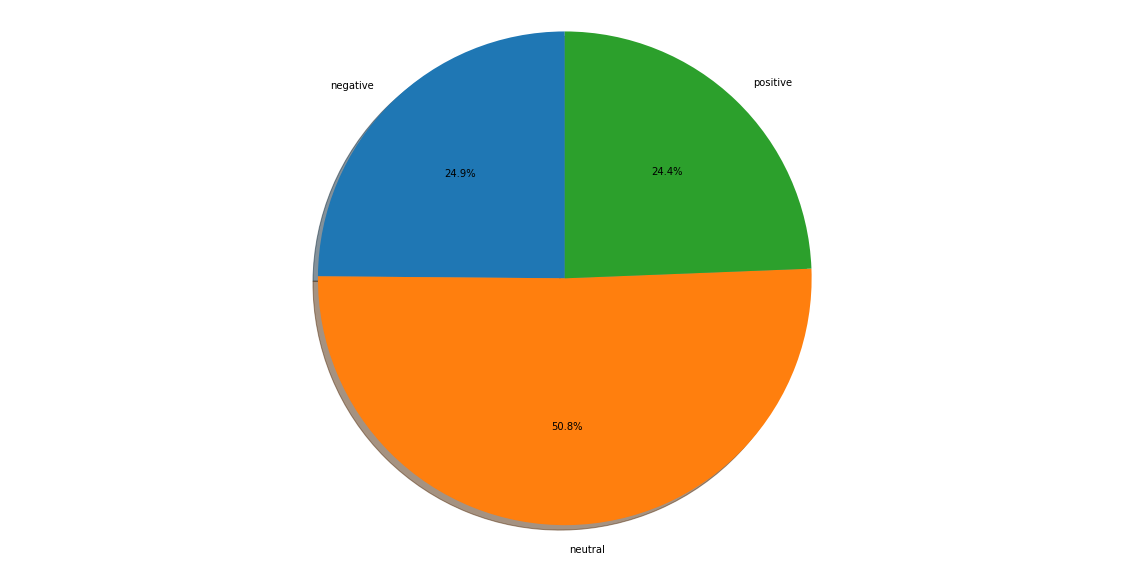

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
fig1, ax1 = plt.subplots()
ax1.pie(vid_score, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()